In [1]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load the audio file with background noise
input_file = 'piano_cleaned.wav'

try:
    sample_rate, audio_data = wavfile.read(input_file)
    print(f"Loaded audio file: {input_file}")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Audio shape: {audio_data.shape}")
    print(f"Duration: {len(audio_data) / sample_rate:.2f} seconds")
    
    # Convert to float32 for processing
    if audio_data.dtype == np.int16:
        audio_float = audio_data.astype(np.float32) / 32768.0
    elif audio_data.dtype == np.int32:
        audio_float = audio_data.astype(np.float32) / 2147483648.0
    else:
        audio_float = audio_data.astype(np.float32)
    
    # If stereo, convert to mono
    if len(audio_float.shape) > 1:
        audio_float = np.mean(audio_float, axis=1)
        print("Converted stereo to mono")
    
    print(f"Audio range: [{np.min(audio_float):.3f}, {np.max(audio_float):.3f}]")
    
except FileNotFoundError:
    print(f"File {input_file} not found. Trying alternative files...")
    # Try alternative files
    for alt_file in ['piano_with_noise.wav', 'piano_melody_with_noise.wav']:
        try:
            sample_rate, audio_data = wavfile.read(alt_file)
            input_file = alt_file
            print(f"Loaded audio file: {input_file}")
            if audio_data.dtype == np.int16:
                audio_float = audio_data.astype(np.float32) / 32768.0
            elif audio_data.dtype == np.int32:
                audio_float = audio_data.astype(np.float32) / 2147483648.0
            else:
                audio_float = audio_data.astype(np.float32)
            
            if len(audio_float.shape) > 1:
                audio_float = np.mean(audio_float, axis=1)
            
            break
        except FileNotFoundError:
            continue


Loaded audio file: piano_with_background.wav
Sample rate: 44100 Hz
Audio shape: (352800,)
Duration: 8.00 seconds
Audio range: [-0.796, 0.886]


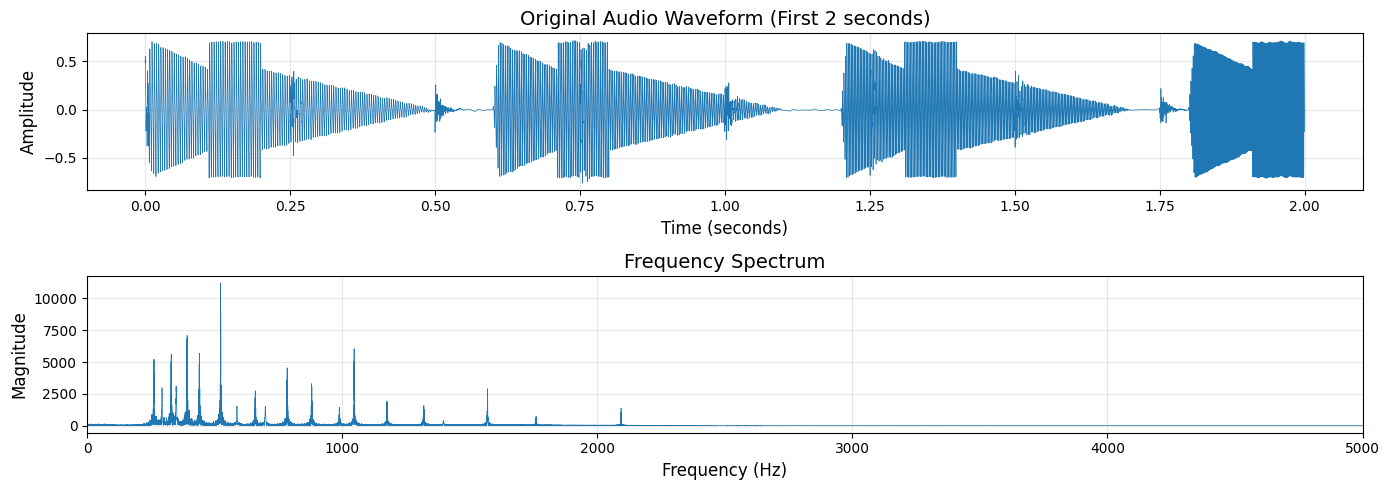

In [3]:
# Visualize the original audio waveform
duration = len(audio_float) / sample_rate
time_axis = np.linspace(0, duration, len(audio_float))

plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(time_axis[:int(2 * sample_rate)], audio_float[:int(2 * sample_rate)], linewidth=0.5)
plt.title('Original Audio Waveform (First 2 seconds)', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)

# Frequency spectrum
plt.subplot(2, 1, 2)
frequencies = fftfreq(len(audio_float), 1/sample_rate)
fft_audio = fft(audio_float)
magnitude = np.abs(fft_audio)
# Only show positive frequencies
positive_freq_idx = frequencies >= 0
plt.plot(frequencies[positive_freq_idx][:len(frequencies)//2], 
         magnitude[positive_freq_idx][:len(frequencies)//2], linewidth=0.5)
plt.title('Frequency Spectrum', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.xlim(0, 5000)  # Show up to 5kHz
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
def remove_background_noise_spectral_subtraction(audio, sample_rate, noise_factor=0.5):
    """
    Remove background noise using spectral subtraction
    """
    # Compute FFT
    fft_audio = fft(audio)
    magnitude = np.abs(fft_audio)
    phase = np.angle(fft_audio)
    
    # Estimate noise from the magnitude spectrum
    # Assume noise is present in low magnitude bins
    noise_estimate = np.percentile(magnitude, 10) * noise_factor
    
    # Subtract noise estimate
    cleaned_magnitude = magnitude - noise_estimate
    cleaned_magnitude = np.maximum(cleaned_magnitude, magnitude * 0.01)  # Floor
    
    # Reconstruct signal
    cleaned_fft = cleaned_magnitude * np.exp(1j * phase)
    cleaned_audio = np.real(ifft(cleaned_fft))
    
    return cleaned_audio.astype(np.float32)

def remove_noise_with_filtering(audio, sample_rate):
    """
    Remove clapping and ambient noise using band-stop filtering
    Clapping: 200-2000 Hz
    Ambient noise: < 100 Hz
    Piano frequencies: 261-523 Hz (C4-C5) - preserve these!
    """
    # Remove very low frequencies (ambient noise)
    # High-pass filter to remove frequencies below 80 Hz (preserve some piano harmonics)
    b_high, a_high = signal.butter(4, 80, btype='high', fs=sample_rate)
    audio_filtered = signal.filtfilt(b_high, a_high, audio)
    
    # Remove high frequency components from clapping (above 3000 Hz)
    b_low2, a_low2 = signal.butter(4, 4000, btype='low', fs=sample_rate)
    audio_filtered = signal.filtfilt(b_low2, a_low2, audio_filtered)
    
    # Selectively remove clapping frequencies that don't overlap with piano
    # Piano is 261-523 Hz, so we can safely remove:
    # - Very low frequencies from clapping (150-250 Hz) - careful, some piano harmonics here
    # - High clapping frequencies (1500-3000 Hz)
    
    # Remove high clapping frequencies (1500-4000 Hz) with a band-stop
    b_stop1, a_stop1 = signal.butter(4, [1500, 4000], btype='bandstop', fs=sample_rate)
    audio_filtered = signal.filtfilt(b_stop1, a_stop1, audio_filtered)
    
    # Gently attenuate mid-range clapping frequencies (800-1500 Hz) but preserve piano harmonics
    # Use a gentler filter here
    b_stop2, a_stop2 = signal.butter(2, [800, 1500], btype='bandstop', fs=sample_rate)
    audio_filtered = signal.filtfilt(b_stop2, a_stop2, audio_filtered)
    
    return audio_filtered.astype(np.float32)

def adaptive_noise_reduction(audio, sample_rate):
    """
    Adaptive noise reduction using Wiener-like filtering
    """
    # Split audio into windows for processing
    window_size = int(0.05 * sample_rate)  # 50ms windows
    overlap = window_size // 2
    step_size = window_size - overlap
    
    cleaned_audio = np.zeros_like(audio)
    
    for i in range(0, len(audio) - window_size, step_size):
        window = audio[i:i + window_size]
        
        # Apply window function
        window_func = np.hanning(len(window))
        windowed = window * window_func
        
        # FFT
        fft_window = fft(windowed)
        magnitude = np.abs(fft_window)
        phase = np.angle(fft_window)
        
        # Estimate noise floor (lower magnitude bins)
        noise_floor = np.percentile(magnitude, 15)
        
        # Spectral subtraction
        snr_estimate = magnitude / (noise_floor + 1e-10)
        gain = np.maximum(0, 1 - 0.5 / snr_estimate)  # Wiener-like gain
        
        # Apply gain
        cleaned_magnitude = magnitude * gain
        cleaned_fft = cleaned_magnitude * np.exp(1j * phase)
        cleaned_window = np.real(ifft(cleaned_fft))
        
        # Reconstruct
        end_idx = min(i + window_size, len(cleaned_audio))
        actual_len = end_idx - i
        cleaned_audio[i:end_idx] += cleaned_window[:actual_len] * window_func[:actual_len]
    
    return cleaned_audio.astype(np.float32)

print("Noise removal functions defined!")


Noise removal functions defined!


In [5]:
# Method 1: Frequency filtering to remove clapping and ambient noise
print("Applying frequency filtering...")
cleaned_audio_filter = remove_noise_with_filtering(audio_float, sample_rate)

# Normalize
cleaned_audio_filter = cleaned_audio_filter / np.max(np.abs(cleaned_audio_filter)) * 0.9

print("Frequency filtering complete!")
print(f"Cleaned audio range: [{np.min(cleaned_audio_filter):.3f}, {np.max(cleaned_audio_filter):.3f}]")


Applying frequency filtering...
Frequency filtering complete!
Cleaned audio range: [-0.861, 0.900]


In [6]:
# Method 2: Spectral subtraction
print("Applying spectral subtraction...")
cleaned_audio_spectral = remove_background_noise_spectral_subtraction(audio_float, sample_rate, noise_factor=0.6)

# Normalize
max_val = np.max(np.abs(cleaned_audio_spectral))
if max_val > 0:
    cleaned_audio_spectral = cleaned_audio_spectral / max_val * 0.9

print("Spectral subtraction complete!")
print(f"Cleaned audio range: [{np.min(cleaned_audio_spectral):.3f}, {np.max(cleaned_audio_spectral):.3f}]")


Applying spectral subtraction...
Spectral subtraction complete!
Cleaned audio range: [-0.808, 0.900]


In [7]:
# Method 3: Combined approach (filtering + spectral subtraction)
print("Applying combined noise reduction...")

# First apply frequency filtering
temp_cleaned = remove_noise_with_filtering(audio_float, sample_rate)
# Then apply spectral subtraction
cleaned_audio_combined = remove_background_noise_spectral_subtraction(temp_cleaned, sample_rate, noise_factor=0.4)

# Normalize
max_val = np.max(np.abs(cleaned_audio_combined))
if max_val > 0:
    cleaned_audio_combined = cleaned_audio_combined / max_val * 0.9

print("Combined noise reduction complete!")
print(f"Cleaned audio range: [{np.min(cleaned_audio_combined):.3f}, {np.max(cleaned_audio_combined):.3f}]")

# Use the combined method as the final cleaned audio
cleaned_audio = cleaned_audio_combined


Applying combined noise reduction...
Combined noise reduction complete!
Cleaned audio range: [-0.861, 0.900]


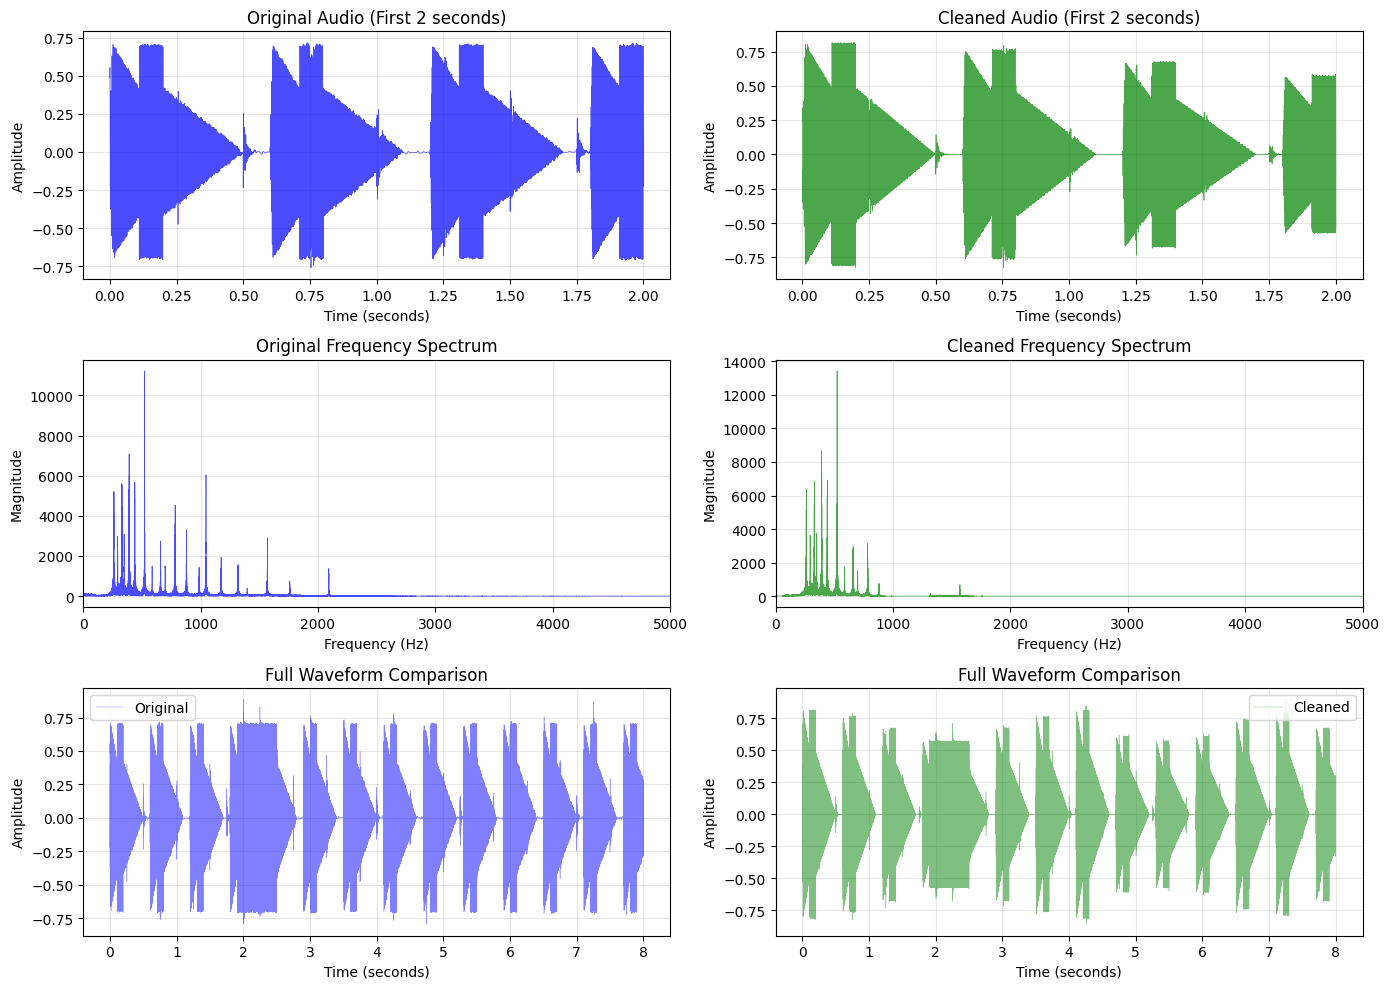


Noise Reduction Metrics:
Original noise level (std): 0.2518
Cleaned noise level (std): 0.2785
Noise reduction: -0.87 dB


In [8]:
# Compare original and cleaned audio
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Time domain - first 2 seconds
time_2sec = time_axis[:int(2 * sample_rate)]
axes[0, 0].plot(time_2sec, audio_float[:int(2 * sample_rate)], linewidth=0.5, color='blue', alpha=0.7)
axes[0, 0].set_title('Original Audio (First 2 seconds)', fontsize=12)
axes[0, 0].set_xlabel('Time (seconds)', fontsize=10)
axes[0, 0].set_ylabel('Amplitude', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time_2sec, cleaned_audio[:int(2 * sample_rate)], linewidth=0.5, color='green', alpha=0.7)
axes[0, 1].set_title('Cleaned Audio (First 2 seconds)', fontsize=12)
axes[0, 1].set_xlabel('Time (seconds)', fontsize=10)
axes[0, 1].set_ylabel('Amplitude', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Frequency spectrum
frequencies = fftfreq(len(audio_float), 1/sample_rate)
fft_original = fft(audio_float)
fft_cleaned = fft(cleaned_audio)
magnitude_orig = np.abs(fft_original)
magnitude_clean = np.abs(fft_cleaned)

positive_freq_idx = frequencies >= 0
freq_pos = frequencies[positive_freq_idx][:len(frequencies)//2]

axes[1, 0].plot(freq_pos, magnitude_orig[positive_freq_idx][:len(frequencies)//2], 
                linewidth=0.5, color='blue', alpha=0.7)
axes[1, 0].set_title('Original Frequency Spectrum', fontsize=12)
axes[1, 0].set_xlabel('Frequency (Hz)', fontsize=10)
axes[1, 0].set_ylabel('Magnitude', fontsize=10)
axes[1, 0].set_xlim(0, 5000)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(freq_pos, magnitude_clean[positive_freq_idx][:len(frequencies)//2], 
                linewidth=0.5, color='green', alpha=0.7)
axes[1, 1].set_title('Cleaned Frequency Spectrum', fontsize=12)
axes[1, 1].set_xlabel('Frequency (Hz)', fontsize=10)
axes[1, 1].set_ylabel('Magnitude', fontsize=10)
axes[1, 1].set_xlim(0, 5000)
axes[1, 1].grid(True, alpha=0.3)

# Full waveform overlay
axes[2, 0].plot(time_axis, audio_float, linewidth=0.3, color='blue', alpha=0.5, label='Original')
axes[2, 0].set_title('Full Waveform Comparison', fontsize=12)
axes[2, 0].set_xlabel('Time (seconds)', fontsize=10)
axes[2, 0].set_ylabel('Amplitude', fontsize=10)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(time_axis, cleaned_audio, linewidth=0.3, color='green', alpha=0.5, label='Cleaned')
axes[2, 1].set_title('Full Waveform Comparison', fontsize=12)
axes[2, 1].set_xlabel('Time (seconds)', fontsize=10)
axes[2, 1].set_ylabel('Amplitude', fontsize=10)
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate noise reduction metrics
noise_level_original = np.std(audio_float)
noise_level_cleaned = np.std(cleaned_audio)
reduction_db = 20 * np.log10(noise_level_original / (noise_level_cleaned + 1e-10))

print(f"\nNoise Reduction Metrics:")
print(f"Original noise level (std): {noise_level_original:.4f}")
print(f"Cleaned noise level (std): {noise_level_cleaned:.4f}")
print(f"Noise reduction: {reduction_db:.2f} dB")


In [9]:
# Save the cleaned audio
output_filename = 'piano_cleaned.wav'
cleaned_audio_int16 = (cleaned_audio * 32767).astype(np.int16)
wavfile.write(output_filename, sample_rate, cleaned_audio_int16)
print(f"Cleaned audio saved to: {output_filename}")

# Also save the filtered version for comparison
output_filtered = 'piano_filtered.wav'
cleaned_filter_int16 = (cleaned_audio_filter * 32767).astype(np.int16)
wavfile.write(output_filtered, sample_rate, cleaned_filter_int16)
print(f"Filtered audio saved to: {output_filtered}")


Cleaned audio saved to: piano_cleaned.wav
Filtered audio saved to: piano_filtered.wav


In [10]:
# Play the cleaned audio (optional)
try:
    from IPython.display import Audio, display
    
    print("\nOriginal audio:")
    display(Audio(audio_float, rate=sample_rate))
    
    print("\nCleaned audio:")
    display(Audio(cleaned_audio, rate=sample_rate))
    
except Exception as e:
    print("To play audio in Jupyter, install IPython.display")
    print(f"Audio files saved:")
    import os
    print(f"  - {os.path.abspath(output_filename)}")
    print(f"  - {os.path.abspath(output_filtered)}")



Original audio:



Cleaned audio:
